# Integration of the Kepler problem with Taylor's method in `Julia`

#### L. Benet, Instituto de Ciencias Físicas, UNAM
benet < AT > fis.unam.mx

## I. The Taylor Integrator

-------

Taylor's integration method for ODEs is quite powerful, allowing to reach a precision comparable to round-off errors in one time-step. While the equations of motion can be in general easily implemented, an efficient implementation requires additional work. Below, we shall show two distinct implementations of the equations of motion for the Kepler problem, which shows how to optimize the running-time; see [TaylorIntegration.jl](https://github.com/PerezHz/TaylorIntegration.jl) for a yet non-optimized implementation.

**NOTE** 

Below we use `julia` version 0.4.7 (0.4.8-pre+1) as the kernel, though it works using Julia v0.5.

In [1]:
println(VERSION)

using Compat

0.4.8-pre+1


We load first the relevant package: [TaylorSeries.jl][1]

[1]: http://github.com/lbenet/TaylorSeries.jl

In [2]:
using TaylorSeries

    /(TaylorSeries.Taylor1{#T<:Real}, #T<:Real) at /Users/benet/.julia/v0.4/TaylorSeries/src/Taylor1.jl:261
is ambiguous with: 
    /(TaylorSeries.Taylor1{Base.Rational{#T<:Integer}}, #S<:Union{Base.Complex, Real}) at /Users/benet/.julia/v0.4/TaylorSeries/src/Taylor1.jl:254.
To fix, define 
    /(TaylorSeries.Taylor1{_<:Base.Rational{#T<:Integer}}, _<:Base.Rational{#T<:Integer})
before the new definition.


The following *parameters* are set for the integrator:

- `ordenTaylor`: Order of the Taylor polynomials considered
- `epsAbs`: Absolute value set for the last (*and* the one-before-last) term of the Taylor expansion of the dynamical variables. This value is used to define an integration step and represents a measure of the error. Notice below that this value is smaller than `eps(1.0)`.

In [3]:
# Parámetros para el integrador de Taylor
const _ordenTaylor = 28
const _epsAbs = 1.0e-20

println(" Taylor order = $_ordenTaylor\n Eps = $_epsAbs\n")

 Taylor order = 28
 Eps = 1.0e-20



The Taylor method works as follows: The equations of motion and the initial conditions $x(t_0)$, $y(t_0)$, $v_x(t_0)$, $v_y(t_0)$, are used to obtain *recursively* each term of the Taylor expansion of the dynamical variables, exploiting the relation
$$
x_{[n+1]} = \frac{f_{[n]}(x,t)}{n+1}.
$$
Here, $f_{[n]}(x,t)$ is the $n$-th (normalized) Taylor coefficient of $f(x,t)$ in terms of the independent variable $t$, where $f(x,t)$ is the rhs of the equation of motion $\dot{x} = f(x,t)$. Likewise, $x_{[n]}$ is the $n$-th Taylor coefficient for the dependent variable $x(t)$, expanded around $x(t_0)=x_{[0]}$. The latter corresponds to the initial condition.

Once all Taylor coefficients are obtained up to a maximum order of the Taylor expansion, which is large enough to ensure convergece of the series, the last two terms of the expansion are used to determine the step size $h$ for the integration together with the value of `EpsAbs`. (Other methods exist that yield better optimized step-sizes, but these are usually more involved to compute.) Evaluating the Taylor expansion with the step-size yields the actual values of the dynamical variables at $t_1=t_0+h$. These values are then used as new *initial conditions* (at $t_0+h$) and everything is iterated.


Except for the actual implementation of the equations of motion (the *jet*) discussed below, the following functions do what we just described:

- `taylorStepper`: carries one step of the integration from $t_0$ to $t_1=t_0+h$, returning h and the value of the dynamical variables evaluated at $t_1$. This routine depends on a user-supplied routine that performs the computation of the Taylor coefficients of all dynamical variables, i.e., that implements the calculation of the jet (`jetEqs`). This routine has as input value a vector with the dynamical variables.
- `stepsize`: Returns the integration step ($h$) from the Taylor expansion coefficients of *one* dynamical variable and `epsAbs`, as given by 
$ h = \min[\, (\epsilon/x^{[p-1]})^{1/(p-1)}, (\epsilon/x^{[p]})^{1/p}\, ], $
where $p$ is the order of the Taylor polynomial, $x^{[r]}$ is the $r$-order Taylor coefficient (the $r$-th derivative divided by $r!$), and $\epsilon={\tt epsAbs}$. 


In [4]:
# Returns stepsize of the integration and a vector with the updated values of the dependent
# variables
function taylorStepper{T<:Real}( jetEqs::Function, vec0::Array{T,1} )
    
    n = length( vec0 )

    vec0T = Array(Taylor1{T},n)
    @simd for i in eachindex(vec0)
        @inbounds vec0T[i] = Taylor1([vec0[i]], _ordenTaylor)
    end

    # Jets
    vec1T = jetEqs( vec0 )
    
    # Step-size
    hh = Inf
    for i in eachindex(vec1T)
        @inbounds h1 = stepsize( vec1T[i], _epsAbs )
        hh = min( hh, h1 )
    end
    
    # Values at t0+h
    @simd for i in eachindex(vec0)
        @inbounds vec0[i] = evaluate( vec1T[i], hh )
    end
    
    return hh, vec0
end

taylorStepper (generic function with 1 method)

In [5]:
# Returns the maximum step size from epsilon and the last two coefficients of the x-Taylor series 
function stepsize{T<:Real}(x::Taylor1{T}, epsilon::Float64)
    ord = x.order
    h = Inf
    for k in [ord-1, ord]
        kinv = 1.0/k
        aux = abs( x[k+1] )
        h = min(h, (epsilon/aux)^kinv)
    end
    return h
end

stepsize (generic function with 1 method)

## II. The Kepler problem

-------

As a concrete example, we numerically integrate the cartesian equations of motion of the (planar) [Kepler problem](https://en.wikipedia.org/wiki/Kepler_problem):

\begin{eqnarray}
\dot{x} &=& v_x,\\
\dot{y} &=& v_y,\\
\dot{v}_x &=& - \frac{G M x}{(x^2 + y^2)^{3/2}},\\
\dot{v}_y &=& - \frac{G M y}{(x^2 + y^2)^{3/2}}.
\end{eqnarray}

For concreteness, we fix $\mu = GM = 1$, and Kepler's third law defines the units of time in terms of those of distance: $T= 2\pi a^{3/2}$. The origin is the center of mass of the two bodies, so $x$ and $y$ above are actually relative coordinates to the center of mass. We choose the $x$-axis to be parallel to the major axis of the ellipse.

The initial conditions for the particle are set at periapse, which we locate on the positive x-axis. Using the semimajor axis $a$ and the eccentricity $e$, we have
$$ 
x_0 = a (1-e),\\
y_0 = 0,\\
v_{x_0} = 0,\\
v_{y_0} = \frac{l_z}{x_0} = m \frac{\sqrt{\mu a (1-e^2)}}{x_0},
$$
where $l_z$ is the angular momentum. Below we set the mass $m$ equal to 1.

In [6]:
const mu = GM = 1.0

const masa = 1.0
const semieje = 1.0
const excentricidad = 0.8

println(" mass = $masa\n a = $semieje\n e = $excentricidad\n")

 mass = 1.0
 a = 1.0
 e = 0.8



The following functions allow us to calculate the energy and angular momentum using cartesian coordinates or the semimajor axis and eccentricity of the orbit:

In [7]:
function energy{T<:Real}( x::T, y::T, vx::T, vy::T )
    eneCin = 0.5*(vx*vx + vy*vy)
    r = sqrt( x*x + y*y)
    enePot = -GM*masa/r
    return eneCin + enePot
end
energy{T<:Real}(a::T) = - 0.5*GM*masa/a

energy (generic function with 2 methods)

In [8]:
lz{T<:Real}( a::T, e::T ) = masa * sqrt( GM*a*(1-e^2) )
lz1{T<:Real}( x::T, y::T, vx::T, vy::T ) = masa*( x*vy - y*vx )

lz1 (generic function with 1 method)

As mentioned above, we set the initial conditions in cartesian coordinates from the values of the semimajor axis and eccentricity.

In [9]:
function iniCond{T<:Real}(a::T, e::T)
    x0  = a*(1-e)
    vy0 = lz(a, e) / x0
    y0  = zero(vy0)
    vx0 = zero(vy0)
    return x0, y0, vx0, vy0
end

iniCond (generic function with 1 method)

## III. Taylor integration of the Kepler problem

-------

As mentioned above, Taylor's integration method is quite powerful. Yet, the equations of motion have to be implemented individually, and this involves a bit more than simply defining a function which contains the equations of motion, although the latter can actually be implemented just like that, which is paid back in performance.

Below, the functions `jetKepler1` and `jetKepler2` are two implementations of the equations of motion for the Kepler problem. Both return a vector that contains the Taylor series for the dynamical variables, taking as input a vector of Taylor coefficients.

The former function is an *almost* straight forward implementation of the equations of motion, except for the fact that we have to use `Taylor`-type variables. The latter yields the same results, but the implementation is done by splitting the equations of motion in unary and binary (elementary) functions and operations. This second method is quite *hand-crafted* to the actual problem, and it is not the most explicit way of doing this; yet, it turns out to be much more efficient than the former.

In [10]:
function jetKepler1{T<:Real}( vec::Array{T,1} )

    xT = Taylor1(vec[1], _ordenTaylor)
    yT = Taylor1(vec[2], _ordenTaylor)
    vxT = Taylor1(vec[3], _ordenTaylor)
    vyT = Taylor1(vec[4], _ordenTaylor)


    for k = 0:_ordenTaylor-1
        knext = k+1
        # Taylor expansions up to order k
        # This part makes it somewhat slower the implementations, since there
        # are many operations which are completely superfluous
        xTt = Taylor1( xT[1:k+1], k)
        yTt = Taylor1( yT[1:k+1], k)
        vxTt = Taylor1( vxT[1:k+1], k)
        vyTt = Taylor1( vyT[1:k+1], k)
        # Eqs of motion <--- This as straight forward as it can be
        xDot = vxTt
        yDot = vyTt
        rrt = ( xTt^2 + yTt^2 )^(3/2)
        vxDot = -GM * xTt / rrt
        vyDot = -GM * yTt / rrt
        # The equations of motion define the recurrencies
        xT[knext+1]  = xDot[knext] / knext
        yT[knext+1]  = yDot[knext] / knext
        vxT[knext+1] = vxDot[knext] / knext
        vyT[knext+1] = vyDot[knext] / knext
    end
    
    return Taylor1[ xT, yT, vxT, vyT ]
end

jetKepler1 (generic function with 1 method)

In [11]:
function jetKepler2{T<:Real}( vec::Array{T,1} )

    xT = Taylor1(vec[1], _ordenTaylor)
    yT = Taylor1(vec[2], _ordenTaylor)
    vxT = Taylor1(vec[3], _ordenTaylor)
    vyT = Taylor1(vec[4], _ordenTaylor)

    # Auxiliary quantities
    x2T = zeros( T, _ordenTaylor+1 )
    y2T = zeros( T, _ordenTaylor+1 )
    sT  = zeros( T, _ordenTaylor+1 )
    rT3 = zeros( T, _ordenTaylor+1 )
    Fx  = zeros( T, _ordenTaylor+1 )
    Fy  = zeros( T, _ordenTaylor+1 )

    # Now the implementation
    for k = 0:_ordenTaylor-1
        knext = k+1
        # The right-hand size of the eqs of motion
        # This is more adpated for this problem, and avoids many superfluous operations
        x2T[knext] = TaylorSeries.squareHomogCoef(k, xT.coeffs)
        y2T[knext] = TaylorSeries.squareHomogCoef(k, yT.coeffs)
        sT[knext]  = x2T[knext] + y2T[knext]
        rT3[knext] = TaylorSeries.powHomogCoef(k, sT, 1.5, rT3, 0)
        Fx[knext]  = TaylorSeries.divHomogCoef(k, xT.coeffs, rT3, Fx, 0)
        Fy[knext]  = TaylorSeries.divHomogCoef(k, yT.coeffs, rT3, Fy, 0)
        # The equations of motion define the recurrencies
        xT[knext+1]  = vxT[knext] / knext
        yT[knext+1]  = vyT[knext] / knext
        vxT[knext+1] = -GM * Fx[knext] / knext
        vyT[knext+1] = -GM * Fy[knext] / knext
    end
    
    return Taylor1[ xT, yT, vxT, vyT ]
end

jetKepler2 (generic function with 1 method)

The following shows some benchmarks for 10 identic one-step integrations, using both implementations of the equations of motion.

In [12]:
x0, y0, vx0, vy0 = iniCond(semieje, excentricidad)

taylorStepper( jetKepler1, [x0, y0, vx0, vy0] );

timeJK1 = @elapsed begin
    for i=1:10
        taylorStepper( jetKepler1, [x0, y0, vx0, vy0] );
    end
end
taylorStepper( jetKepler1, [x0, y0, vx0, vy0] )

(0.017379273627668643,[0.19626418116550612,0.05181472066492753,-0.42543199148800787,2.944787769051677])

In [13]:
x0, y0, vx0, vy0 = iniCond(semieje, excentricidad)

taylorStepper( jetKepler2, [x0, y0, vx0, vy0] );

timeJK2 = @elapsed begin
    for i=1:10
        taylorStepper( jetKepler2, [x0, y0, vx0, vy0] );
    end
end
taylorStepper( jetKepler2, [x0, y0, vx0, vy0] )


(0.017379273627668643,[0.19626418116550612,0.05181472066492753,-0.42543199148800787,2.944787769051677])

In [14]:
println( "timeJK1 = $(timeJK1)   timeJK2 = $(timeJK2) ")
tau = timeJK1/timeJK2

timeJK1 = 0.001156201   timeJK2 = 0.000211803 


5.458850913348725

The results are identic, as it should be; yet, the elapsed time is somewhat shorter when using `jetKepler2`. The numbers clearly show that it is worth taking the time to construct the jet as in `jetKepler2`.

Now, we carry out a long integration of this rather eccentric keplerian orbit (eccentricity is 0.8). Everything needed is included in the function `keplerIntegration`.

In [15]:
function keplerIntegration( a::Float64, e::Float64, time_max::Float64, jetEqs::Function )
    # Initial conditions, energy and angular momentum
    t0 = 0.0
    x0, y0, vx0, vy0 = iniCond(a, e)
    ene0 = energy(x0, y0, vx0, vy0)
    lz0 = lz1(x0, y0, vx0, vy0)
    
    # Change, measured in the local `eps` of the change of energy and angular momentum
    eps_ene = eps(ene0); dEne = zero(Int)
    eps_lz = eps(lz0); dLz = zero(Int)
    
    # Vectors to plot the orbit with PyPlot
    tV, xV, yV, vxV, vyV = Float64[], Float64[], Float64[], Float64[], Float64[]
    DeneV, DlzV = Int[], Int[]
    push!(tV, t0)
    push!(xV, x0)
    push!(yV, y0)
    push!(vxV, vx0)
    push!(vyV, vy0)
    push!(DeneV, zero(Int))
    push!(DlzV, zero(Int))
    
    # This is the main loop; we include a minimum step size for security
    dt = 1.0
    while t0 < time_max && dt>1.0e-8
        # Here we integrate
        dt, (x1, y1, vx1, vy1) = taylorStepper( jetEqs, [x0, y0, vx0, vy0] );
        t0 += dt
        push!(tV,t0)
        push!(xV,x1)
        push!(yV,y1)
        push!(vxV, vx1)
        push!(vyV, vy1)
        eneEnd = energy(x1, y1, vx1, vy1)
        lzEnd = lz1(x1, y1, vx1, vy1)
        dEne = trunc( Int, (eneEnd-ene0)/eps_ene )
        dLz  = trunc( Int, (lzEnd-lz0)/eps_lz )
        push!(DeneV, dEne)
        push!(DlzV, dLz)
        x0, y0, vx0, vy0 = x1, y1, vx1, vy1
    end

    return tV, xV, yV, DeneV, DlzV
end

keplerIntegration (generic function with 1 method)

In [16]:
#jetKepler1
tV1, xV1, yV1, DeneV1, DlzV1 = keplerIntegration( semieje, excentricidad, 2pi, jetKepler1);
@time tV1, xV1, yV1, DeneV1, DlzV1 = 
    keplerIntegration( semieje, excentricidad, 1000*2pi, jetKepler1);

  4.623210 seconds (47.67 M allocations: 3.549 GB, 6.94% gc time)


In [17]:
#jetKepler2
tV2, xV2, yV2, DeneV2, DlzV2 = keplerIntegration( semieje, excentricidad, 2pi, jetKepler2);
@time tV2, xV2, yV2, DeneV2, DlzV2 = 
    keplerIntegration( semieje, excentricidad, 1000*2pi, jetKepler2);

  0.882801 seconds (16.18 M allocations: 494.170 MB, 4.83% gc time)


Checking the consistency of the results after 1000 periods

In [18]:
tV1[end] == tV2[end], yV1[end] == yV2[end]

(true,true)

The minimum value of the step-size:

In [19]:
minimum([tV1[i+1]-tV1[i] for i=1:length(tV1)-1])

0.017379273627668643

which, in units of the orbital period, is:

In [20]:
ans/(2pi)

0.0027659973051900803

The average step-size is:

In [21]:
(tV1[end]-tV1[1])/(length(tV1)-1)

0.14405720621814588

In [22]:
ans/(2pi)

0.02292741645762644

Now let us plot the trajectory using `PyPlot`:

In [23]:
using PyPlot

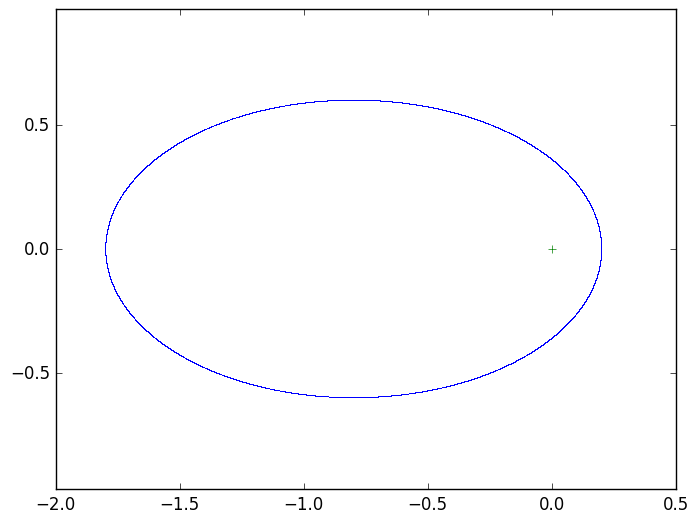

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32f8074d0>
 PyObject <matplotlib.lines.Line2D object at 0x32f807650>

In [24]:
axis("equal")
plot(xV1, yV1, ",", [0], [0], "+")

Here we also plot the absolute change of energy and angular momentum as a function of time, in units of the 
local `eps` values for the initial quantities.

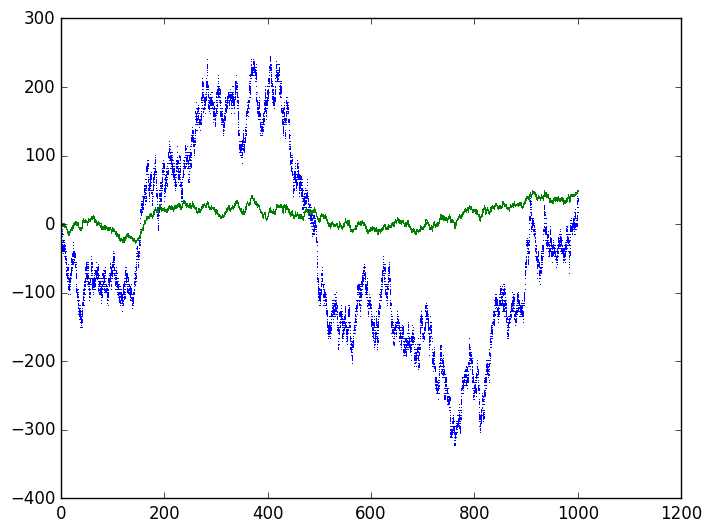

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32fe99d90>
 PyObject <matplotlib.lines.Line2D object at 0x32fe99e10>

In [25]:
plot(tV2/(2pi), DeneV2, ",", tV2/(2pi), DlzV2, ",")

In [26]:
tV2, xV2, yV2, DeneV2, DlzV2 = 
    keplerIntegration( semieje, excentricidad, 2pi*10000.0, jetKepler2);

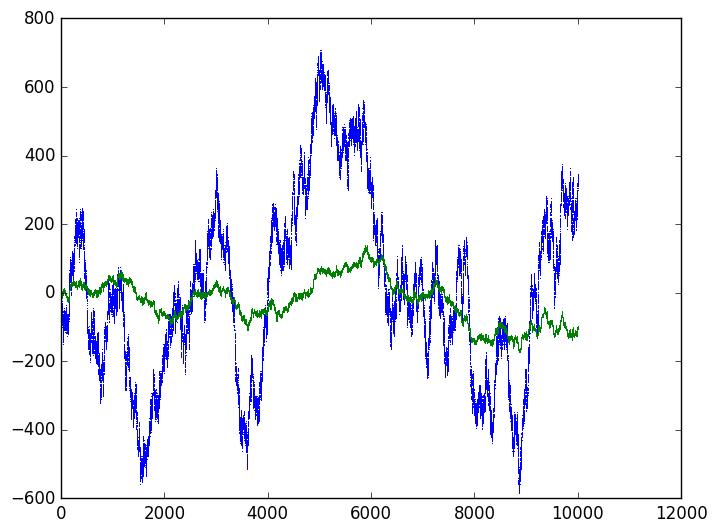

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x330da16d0>
 PyObject <matplotlib.lines.Line2D object at 0x330da1750>

In [27]:
plot(tV2/(2pi), DeneV2, ",", tV2/(2pi), DlzV2, ",")

In [28]:
maximum(abs(DeneV2)), maximum(abs(DlzV2))

(704,176)

In [29]:
maximum(abs(DeneV2))*eps(1.0), maximum(abs(DlzV2))*eps(1.0)

(1.5631940186722204e-13,3.907985046680551e-14)

The absolute change of this quantities, after 10000 periods, is for the energy $704\ {\rm eps}\sim 1.56\times 10^{-13}$, and for the angular momentum $176\ {\rm eps}\sim 3.9\times10^{-14}$. The changes in time of these queantities have a random walk like behaviour, pointing out that they are due to the round-off errors in the computations.

The numerical precision attained is **really good**.